# Setup

In [174]:
! pip install langchain_community tiktoken langchain-ollama ollama langchainhub chromadb langchain bs4 langchain_chroma

In [56]:
# Load env
from dotenv import load_dotenv
load_dotenv(override=True)

True

In [3]:
! source get_host.sh && echo $OLLAMA_HOST > tmp_env.txt
with open('tmp_env.txt') as f:
    OLLAMA_HOST = f.read().strip()
%env OLLAMA_HOST=$OLLAMA_HOST
import os
os.remove("tmp_env.txt")

env: OLLAMA_HOST=http://172.25.208.1:11434


# Indexing

In [ ]:
# Documents
question = "What kinds of pets do I like?"
document = "My favorite pet is a cat."

In [5]:
import tiktoken

def num_tokens_from_string(string: str, encoding_name:str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

num_tokens_from_string(question, "cl100k_base")

8

In [23]:
# Text embedding models
# https://ollama.com/blog/embedding-models
from langchain_ollama import OllamaEmbeddings
# embd = OllamaEmbeddings(model="nomic-embed-text")
embd = OllamaEmbeddings(model=os.environ["OLLAMA_EMBED_MODEL"])
query_result = embd.embed_query(question)
document_result = embd.embed_query(document)
len(query_result)

1024

In [24]:
import numpy as np

def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

similarity = cosine_similarity(query_result, document_result)
print("Cosine Similarity:", similarity)


Cosine Similarity: 0.2761092814708602


In [30]:
# Document Loaders

# Load blog
import bs4
from langchain_community.document_loaders import WebBaseLoader
import os

os.environ['USER_AGENT'] = 'myagent'

loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load()

In [31]:
# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300,
    chunk_overlap=50,
)

# make splits
splits = text_splitter.split_documents(blog_docs)

In [ ]:
# vectorstores
# index

from langchain_ollama import OllamaEmbeddings
from langchain_community.vectorstores import Chroma
vectorstore = Chroma.from_documents(documents=splits,
                                    embedding=OllamaEmbeddings(model=os.environ["OLLAMA_LLM_MODEL"])
                                   )

retriever = vectorstore.as_retriever()

# Retrieval

In [ ]:

from langchain_ollama import OllamaEmbeddings
from langchain_community.vectorstores import Chroma
vectorstore = Chroma.from_documents(documents=splits,
                                    embedding=OllamaEmbeddings(model=os.environ["OLLAMA_EMBED_MODEL"])
                                   )

retriever = vectorstore.as_retriever(search_kwargs={"k": 1})

In [44]:
docs = retriever.get_relevant_documents("What is Task Decomposition?")

In [39]:
len(docs)

1

# Generation

In [41]:
from langchain.prompts import ChatPromptTemplate

# Prompt
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='Answer the question based only on the following context:\n{context}\n\nQuestion: {question}\n'), additional_kwargs={})])

In [ ]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model=os.environ.get("OLLAMA_LLM_MODEL"),
    base_url=os.getenv("OLLAMA_HOST")
)

In [43]:
# chain
chain = prompt | llm

In [46]:
# invoke
chain.invoke({"context": docs, "question": "What is task decomposition?"})

AIMessage(content='Task decomposition is the process of breaking down a complicated task into smaller and simpler steps. It involves using techniques such as Chain of Thought (CoT), Tree of Thoughts, or other methods to analyze the problem and generate multiple possible solutions at each step. The goal is to make the task more manageable and understandable for an agent (e.g., a language model) by transforming complex tasks into multiple smaller ones.', additional_kwargs={}, response_metadata={'model': 'llama3.2:3b', 'created_at': '2025-08-26T18:10:17.0767458Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1250924700, 'load_duration': 58223700, 'prompt_eval_count': 332, 'prompt_eval_duration': 22225900, 'eval_count': 82, 'eval_duration': 1169818900, 'model_name': 'llama3.2:3b'}, id='run--90d69d2b-33ca-4052-95ef-166e61672b1d-0', usage_metadata={'input_tokens': 332, 'output_tokens': 82, 'total_tokens': 414})

In [47]:
# prompt hub
from langchain import hub
prompt_hub_rag = hub.pull("rlm/rag-prompt")
prompt_hub_rag

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

Rag Chains

In [50]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

rag_chain.invoke("What is Task Decomposition")

'According to the provided context, Task Decomposition refers to breaking down complex tasks into smaller and simpler steps, allowing an agent (or a model) to plan ahead and tackle hard tasks more efficiently. This technique is also known as Chain of Thought (CoT), which involves instructing the model to "think step by step" to decompose the task.'

## Multi-Query

In [73]:
from langchain.prompts import ChatPromptTemplate

# mutli-query
template = """You are an AI language model assistant. Your task is to generate five
different versions of the given user question to retrieve relevant documents from a vector
database. By generating multiple perspectives on the user question, your goal is to help the user
overcome some of the limitations of the distance-based similarity search.
Provide these alternative questions separated by only one newline character. Only provide the requested
perspectives without any additional text. Original question: {question}"""
prompt_perspectives = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser
from langchain_ollama import ChatOllama

generate_queries = (
    prompt_perspectives
    | ChatOllama(temperature=0, model=os.environ["OLLAMA_LLM_MODEL"])
    | StrOutputParser()
    | (lambda x: [line for line in x.split('\n') if line.strip()])
)

In [74]:
from langchain.load import dumps, loads

def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # get unique documents
    unique_docs = list(set(flattened_docs))
    # return
    return [loads(doc) for doc in unique_docs]

# retrieve
question = "What is task decomposition for LLM agents?"
retrieval_chain = generate_queries | retriever.map() | get_unique_union
docs = retrieval_chain.invoke({"question": question})
len(docs)

2

In [77]:
from operator import itemgetter
from langchain_ollama import ChatOllama
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}"""

prompt = ChatPromptTemplate.from_template(template)

llm = ChatOllama(temperature=0, model=os.environ['OLLAMA_LLM_MODEL'])

final_rag_chain = (
    {"context": retrieval_chain,
     "question": itemgetter("question")}
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question": question})

'According to the text, task decomposition for LLM agents involves breaking down large tasks into smaller, manageable subgoals. This process enables efficient handling of complex tasks.\n\nThere are three ways to perform task decomposition:\n\n1. Using simple prompting with instructions like "Steps for XYZ. 1.", or "What are the subgoals for achieving XYZ?".\n2. Using task-specific instructions, such as "Write a story outline." for writing a novel.\n3. With human inputs.\n\nTask decomposition is used in conjunction with other techniques, such as Chain of Thought (CoT) and Tree of Thoughts (Yao et al. 2023), to help the LLM agent plan ahead and tackle complex tasks.'

## RAG-Fusion

In [78]:
from langchain.prompts import ChatPromptTemplate

# RAG-Fusion: related
template = """You are a helpful assistant that generates multiple search quesries based on a single input entry. \n Output (4 queries:)"""
prompt_rag_fusion = ChatPromptTemplate.from_template(template)

In [79]:
from langchain_core.output_parsers import StrOutputParser
from langchain_ollama import ChatOllama

generate_queries = (
    prompt_perspectives
    | ChatOllama(temperature=0, model=os.environ["OLLAMA_LLM_MODEL"])
    | StrOutputParser()
    | (lambda x: [line for line in x.split('\n') if line.strip()])
)

In [81]:
from langchain.load import dumps, loads

def reciprocal_rank_fusion(results: list[list], k=60):
    """ Reciprocal_rank_fusion that takes multiple lists of ranked documents
        and an optional parameter k used inthe RRF formula """
    
    # initialize a dictionary to hold fused scores for each unique deployment
    fused_scores = {}

    # Iterate through each list of ranked documents
    for docs in results:
        # iterate through each document in the list, with its rank (position in the list)
        for rank, doc in enumerate(docs):
            # Convert the document to a string format to use as a key (assumes documents can be seriealsed to JSON)
            doc_str = dumps(doc)
            # If the document is not yet in the fused_score dictionary, add it with an initial score of 0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            # retrieve the current score of the document
            previous_score = fused_scores[doc_str]
            # update the score of the document using the RRF formula: 1 / (rank + k)
    
    # Sort the docuents based on their fused scores in descending order to get the final reranked results
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    # return the reranked results as a list of tuples, each containing the document and its fused score
    return reranked_results

retrieval_chain_rag_fusion = generate_queries | retriever.map() | reciprocal_rank_fusion
docs = retrieval_chain_rag_fusion.invoke({"question": question})
len(docs)


2

In [82]:
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    {"context": retrieval_chain_rag_fusion,
     "question": itemgetter("question")}
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question": question})

'According to the text, task decomposition for LLM (Large Language Model) agents involves breaking down large tasks into smaller, manageable subgoals. This allows the agent to efficiently handle complex tasks.\n\nThere are three ways to do task decomposition:\n\n1. Using simple prompting: e.g., "Steps for XYZ." or "What are the subgoals for achieving XYZ?"\n2. Using task-specific instructions: e.g., "Write a story outline."\n3. With human inputs.\n\nTask decomposition is one of the key components of a LLM-powered autonomous agent system, along with reflection and refinement.'

## Decomposition

In [86]:
from langchain.prompts import ChatPromptTemplate

# decomposition
template = """You are a helpful assistant that generates multiple sub-questions related to an input question. \n
The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. \n
Do not provide any other text, only provide the generated search queries \n
Generate multiple search queries related to: {question} \n
Output (3 queries):"""
prompt_decomposition = ChatPromptTemplate.from_template(template)

In [87]:
from langchain_ollama import ChatOllama
from langchain_core.output_parsers import StrOutputParser

# LLM
llm = ChatOllama(temperature=0, model=os.environ['OLLAMA_LLM_MODEL'])

# Chain
generate_queries_decomposition = ( prompt_decomposition | llm | StrOutputParser() |  (lambda x: [line for line in x.split('\n') if line.strip()]))

# Run
question = "What are the main components of an LLM-powered autonomous agent system?"
questions = generate_queries_decomposition.invoke({"question": question})
questions

['1. What is the role of a large language model in an autonomous agent system?',
 '2. How do reinforcement learning algorithms contribute to the development of autonomous agents powered by LLMs?',
 '3. What are the key differences between LLM-powered and traditional machine learning approaches for autonomous decision-making?']

In [88]:
# Prompt
template = """Here is the question you need to answer:

\n --- \n {question} \n --- \n

Here is any available background question + answer pairs:

\n -- \n {q_a_pairs} \n --- \n

Here is additional context relevant to the question:

\n --- \n {context} \n --- \n

Use the above context and any background question + answer pairs to answer the question: \n {question}
"""

decomposition_prompt = ChatPromptTemplate.from_template(template)

In [89]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

def format_qa_pair(question, answer):
    """Format Q and A pair"""

    formatted_string = ""
    formatted_string += f"Question: {question}\nAnswer: {answer}\n\n"
    return formatted_string.strip()

# llm 
llm = ChatOllama(temperature=0, model=os.environ['OLLAMA_LLM_MODEL'])

# Generate QA pairs
q_a_pairs = ""
for q in questions:

    rag_chain = (
        {"context": itemgetter("question") | retriever,
         "question": itemgetter("question"),
         "q_a_pairs": itemgetter("q_a_pairs")}
        | decomposition_prompt
        | llm
        | StrOutputParser()
    )

    answer = rag_chain.invoke({"question": q, "q_a_pairs": q_a_pairs})
    q_a_pair = format_qa_pair(q, answer)
    q_a_pairs = q_a_pairs + "\n --- \n" + q_a_pair

q_a_pairs

"\n --- \nQuestion: 1. What is the role of a large language model in an autonomous agent system?\nAnswer: Based on the provided context, a large language model (LLM) plays a crucial role as the brain of an autonomous agent system. In this setup, the LLM functions as the primary controller, complemented by several key components:\n\n1. Planning: The LLM breaks down complex tasks into smaller subgoals, enabling efficient handling of intricate tasks.\n2. Reflection and refinement: The LLM can perform self-criticism and self-reflection over past actions, learning from mistakes and refining them for future steps to improve the quality of final results.\n\nIn summary, the role of a large language model in an autonomous agent system is to serve as the intelligent core controller that enables planning, reflection, and refinement, ultimately driving the agent's decision-making process.\n --- \nQuestion: 2. How do reinforcement learning algorithms contribute to the development of autonomous agen

## Step Back

In [96]:
# Few Shot Examples
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate
examples = [
    {
        "input": "Could the members of the police perform lawful arrests?",
        "output": "What can the members of the police do?",
    },
    {
        "input": "Jan Sindel's was born in what country?",
        "output": "What is Jan Sindel's personal history?",
    },
]
# We now transform these to examples messages
example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}"),
        ("ai", "{output}"),
    ]
)
few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples,
)
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert at world knowledge. Your task is to step back and paraphrase a question to a more generic step-back question, which is easier to answer. You must respond with only one step-back question with no added text. Here are a few examples:"""
        ),
        # Few shot examples
        few_shot_prompt,
        # New question
        ("user", "{question}")
    ]
)
few_shot_prompt

FewShotChatMessagePromptTemplate(examples=[{'input': 'Could the members of the police perform lawful arrests?', 'output': 'What can the members of the police do?'}, {'input': "Jan Sindel's was born in what country?", 'output': "What is Jan Sindel's personal history?"}], input_variables=[], input_types={}, partial_variables={}, example_prompt=ChatPromptTemplate(input_variables=['input', 'output'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], input_types={}, partial_variables={}, template='{input}'), additional_kwargs={}), AIMessagePromptTemplate(prompt=PromptTemplate(input_variables=['output'], input_types={}, partial_variables={}, template='{output}'), additional_kwargs={})]))

In [97]:
generate_queries_step_back = prompt | ChatOllama(temperature=0, model=os.environ['OLLAMA_LLM_MODEL']) | StrOutputParser()
question = "What is task decomposition for LLM agents?"
generate_queries_step_back.invoke({"question": question})

'How do large language models process complex tasks?'

In [99]:
from langchain_core.runnables import RunnableLambda
# Response prompt
response_prompt_template = """You are an expert of world knowledge. I am going to ask you a question. Your response should be comprehensive and

# {normal_context}
# {step_back_context}

# Original Question: {question}
# Answer:"""
response_prompt = ChatPromptTemplate.from_template(response_prompt_template)

chain = (
    {
        # Retrieve context using the normal question
        "normal_context": RunnableLambda(lambda x: x["question"]) | retriever,
        # Retrieve context using the step-back question
        "step_back_context": generate_queries_step_back | retriever,
        # Pass on the question
        "question": lambda x: x["question"],
    }
    | response_prompt
    | ChatOllama(temperature=0, model=os.environ['OLLAMA_LLM_MODEL'])
    | StrOutputParser()
)

chain.invoke({"question": question})

'Task decomposition is a crucial component of LLM-powered autonomous agent systems, enabling the efficient handling of complex tasks by breaking them down into smaller, manageable subgoals. In the context of LLM agents, task decomposition involves instructing the model to "think step by step" and utilize more test-time computation to decompose hard tasks into simpler steps.\n\nThere are several techniques used for task decomposition in LLM-powered agent systems:\n\n1. **Chain of Thought (CoT)**: This technique, introduced by Wei et al. (2022), involves instructing the model to "think step by step" and generate a chain of thoughts that decompose the complex task into smaller steps. CoT transforms big tasks into multiple manageable tasks and sheds light on the model\'s thinking process.\n2. **Tree of Thoughts (ToT)**: This technique, introduced by Yao et al. (2023), extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thoug

## HyDE

In [102]:
from langchain.prompts import ChatPromptTemplate

# HyDE document generation
template = """Please write a scientific paper passage to answer the question
Do not provide any additional text besides the requested answer.
Question: {question}
Passage:"""
prompt_hyde = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser
from langchain_ollama import ChatOllama

generate_docs_for_retrieval = (
    prompt_hyde | ChatOllama(temperature=0, model=os.environ['OLLAMA_LLM_MODEL']) | StrOutputParser()
)

# Run
question = "What is task decomposition for LLM agents?"
generate_docs_for_retrieval.invoke({"question": question})

'Task decomposition for Large Language Model (LLM) agents refers to the process of breaking down complex tasks into smaller, more manageable sub-tasks that can be executed by the model in a hierarchical manner. This approach enables the development of more robust and generalizable LLMs by allowing them to focus on specific aspects of the task at hand, rather than attempting to tackle the entire task simultaneously.\n\nBy decomposing tasks into sub-tasks, LLM agents can leverage their strengths in processing and generating text to address specific components of the task, such as question answering, text classification, or language translation. This hierarchical approach also enables the model to learn more nuanced representations of the task and its sub-tasks, leading to improved performance and generalizability.\n\nTask decomposition has been particularly effective for LLMs in applications such as conversational AI, where complex tasks require the model to understand context, intent, a

In [103]:
# Retrieve
retrieval_chain = generate_docs_for_retrieval | retriever
retrieved_docs = retrieval_chain.invoke({"question": question})
retrieved_docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a

In [105]:
# RAG
template = """Answer the following question based on this context:
{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"context": retrieved_docs, "question": question})

'According to the context, task decomposition for LLM (Large Language Model) agents can be done in three ways:\n\n1. With simple prompting, such as "Steps for XYZ." or "What are the subgoals for achieving XYZ?".\n2. Using task-specific instructions, e.g., "Write a story outline." for writing a novel.\n3. With human inputs.\n\nThis process involves breaking down complex tasks into smaller and simpler steps, allowing the LLM agent to plan ahead and utilize more test-time computation.'

## Routing

In [115]:
! pip install langchain_community tiktoken langchain-ollama langchainhub chromadb langchain youtube-transcript-api pytubefix

### Logical Routing

In [107]:
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_ollama import ChatOllama

# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasoruce: Literal["python_docs", "js_docs", "golang_docs"] = Field(
        ...,
        description="Given a user question choose which datasource would be most relevant for answering their question",
    )

# LLM with function call
llm = ChatOllama(temperature=0, model=os.environ['OLLAMA_LLM_MODEL'])
structured_llm = llm.with_structured_output(RouteQuery)

# Prompt
system = """You are an expert at routing a user question to the appropriate data source.
Based on the programming language the question is referring to, route it to the most relevant data source."""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

# Define router
router = prompt | structured_llm

In [109]:
question = """Why doesn't the following code work:

from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(["human"], "speak in {language}])
prompt.invoke("french")
"""

result = router.invoke({"question": question})
result

RouteQuery(datasoruce='python_docs')

In [110]:
result.datasoruce

'python_docs'

In [112]:
def choose_route(result):
    if "python_docs" in result.datasoruce.lower():
        # Logic here
        return "chain for python_docs"
    elif "js_docs" in result.datasoruce.lower():
        # Logic here
        return "chain for js_docs"
    else:
        # Logic here
        return "chain for golang_docs"

from langchain_core.runnables import RunnableLambda

full_chain = router | RunnableLambda(choose_route)
full_chain.invoke({"question": question})

'chain for python_docs'

### Semantic routing

In [113]:
from langchain.utils.math import cosine_similarity
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_ollama import ChatOllama, OllamaEmbeddings

# Two prompts
physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise and easy to understand manner. \
WHen you don't know the answer you admit that you don't know.

Here is a question:
{query}"""

math_template = """You are a very good mathematician. You are great at answering math questions.\
You are so good because you are able to break down hard problems into their component parts, \
answer the component parts, and then put them together to answer the broader question.

Here is a question:
{query}"""

# Embed prompts
embeddings = OllamaEmbeddings(model=os.environ["OLLAMA_EMBED_MODEL"])
prompt_templates = [physics_template, math_template]
prompt_embeddings = embeddings.embed_documents(prompt_templates)

# Route question to prompt
def prompt_router(input):
    # Embed question
    query_embedding = embeddings.embed_query(input["query"])
    # Compute similarity
    similarity = cosine_similarity([query_embedding], prompt_embeddings)[0]
    most_similar = prompt_templates[similarity.argmax()]
    # Chosen prompt
    print("Using MATH" if most_similar == math_template else "Using PHYSICS")
    return PromptTemplate.from_template(most_similar)

chain = (
    {"query": RunnablePassthrough()}
    | RunnableLambda(prompt_router)
    | ChatOllama(temperature=0, model=os.environ['OLLAMA_LLM_MODEL'])
    | StrOutputParser()
)

print(chain.invoke("What's a black hole"))

Using PHYSICS
A black hole! One of the most fascinating and mysterious objects in the universe.

A black hole is essentially a region in space where the gravitational pull is so strong that nothing, including light, can escape. It's formed when a massive star collapses in on itself and its gravity becomes so strong that it warps the fabric of spacetime around it.

Imagine spacetime as a trampoline: if you place a heavy object, like a bowling ball, on the trampoline, it will warp and curve, creating a depression. Now imagine taking that bowling ball and making it infinitely dense and heavy – that's roughly what happens in a black hole. The gravity is so strong that it creates a boundary called the event horizon, which marks the point of no return.

Once something crosses the event horizon, it's trapped by the black hole's gravity and can't escape. That's why black holes are invisible to us, as not even light can escape to reach our eyes.

But here's the really cool thing about black hol

## Query Construction

In [160]:
## Fix broken pytube
import sys
import pytubefix
sys.modules["pytube"] = pytubefix

## Fix broken YoutubeTranscriptApi
from youtube_transcript_api import YouTubeTranscriptApi

# Patch: alias list_transcripts to list
def patched_list_transcripts(video_id: str):
    api = YouTubeTranscriptApi()
    return api.list(video_id)

YouTubeTranscriptApi.list_transcripts = staticmethod(patched_list_transcripts)

In [166]:
from langchain_community.document_loaders import YoutubeLoader

docs = YoutubeLoader.from_youtube_url("https://www.youtube.com/watch?v=2_Dtmpe9qaQ", add_video_info=True).load()

docs[0].metadata

{'source': '2_Dtmpe9qaQ',
 'title': "Change your profile picture to clippy. I'm serious",
 'description': 'https://www.judiciary.senate.gov/committee-activity/hearings/a-time-for-truth-oversight-of-metas-foreign-relations-and-representations-to-the-united-states-congress\n\nhttps://futurism.com/facebook-beauty-targeted-ads\nhttps://en.wikipedia.org/wiki/United_States_v._Microsoft_Corp.\nhttps://www.youtube.com/watch?v=RwSkwh3nWv8\nhttps://www.youtube.com/watch?v=cayIOCg24bE\nhttps://www.youtube.com/watch?v=tfAchfFXghc',
 'view_count': 4020223,
 'thumbnail_url': 'https://i.ytimg.com/vi/2_Dtmpe9qaQ/sddefault.jpg',
 'publish_date': '2025-08-07 15:09:26',
 'length': 472,
 'author': 'Louis Rossmann'}

In [167]:
import datetime
from typing import Literal, Optional, Tuple
from langchain_core.pydantic_v1 import BaseModel, Field

class TutorialSearch(BaseModel):
    """Search over a database of tutorial videos about a software library."""

    content_search: str = Field(
        ...,
        description="Similarity search query applied to video transcripts.",
    )
    title_search: str = Field(
        ...,
        description=(
            "Alternate version of the content search query to apply to video titles. "
            "Should be succinct and only include key words that coudl be in a video "
            "title."
        ),
    )
    min_view_count: Optional[int] = Field(
        None,
        description="Minimum view count filter, inclusive. Only use if explicity specified.",
    )
    max_view_count: Optional[int] = Field(
        None,
        description="Maximum view count filter, exclusive. Only use if explicity specified.",
    )
    earliest_publish_date: Optional[int] = Field(
        None,
        description="Earliest publish date filter, inclusive. Only use if explicity specified.",
    )
    latest_publish_date: Optional[int] = Field(
        None,
        description="Latist publish date filter, exclusive. Only use if explicity specified.",
    )
    min_length_sec: Optional[int] = Field(
        None,
        description="Minimum video length in seconds, inclusive. Only use if explicity specified.",
    )
    max_length_sec: Optional[int] = Field(
        None,
        description="Maximum video length in seconds, exclusive. Only use if explicity specified.",
    )

    def pretty_print(self) -> None:
        for field in self.__fields__:
            if getattr(self, field) is not None and getattr(self, field) != getattr(
                self.__fields__[field], "default", None
            ):
                print(f"{field}: {getattr(self, field)}")

In [168]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama import ChatOllama

system = """You are and expert at converting user questions into database queries. \
You have access to a database of tutorial video about a software library for building LLM-powered applications \
Given a question, return a database query optimized to retrieve the most relevant results.

If there are acronyms or words you are not familiar with, do not try to rephrase them."""
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)
llm = ChatOllama(temperature=0, model=os.environ['OLLAMA_LLM_MODEL'])
structured_llm = llm.with_structured_output(TutorialSearch)
query_analyzer = prompt | structured_llm

In [169]:
query_analyzer.invoke({"question": "rag from scratch"}).pretty_print()

content_search: rag from scratch tutorial
title_search: rag programming language tutorial
latest_publish_date: 2022


In [ ]:
query_analyzer.invoke({"question": "videos"})

## Indexing

### Multi representation

In [170]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

loader = WebBaseLoader("https://lilianweng.github.io/posts/2024-02-05-human-data-quality/")
docs.extend(loader.load())

In [171]:
import uuid

from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama import ChatOllama

chain = (
    {"doc": lambda x: x.page_content}
    | ChatPromptTemplate.from_template("Summarize the following document:\n\n{doc}")
    | ChatOllama(temperature=0, model=os.environ['OLLAMA_LLM_MODEL'])
    | StrOutputParser()
)

summaries = chain.batch(docs, {"max_concurrency": 5})

In [172]:
summaries

["I'll provide a summary of the text in a concise format, highlighting the main points and key takeaways.\n\n**Summary**\n\nThe text discusses the limitations of Large Language Models (LLMs) in building autonomous agents. The authors highlight five common challenges:\n\n1. **Finite context length**: LLMs struggle with limited communication bandwidth, making it difficult to incorporate historical information and learn from past mistakes.\n2. **Long-term planning and task decomposition**: LLMs find it challenging to adjust plans when faced with unexpected errors, making them less robust compared to humans.\n3. **Reliability of natural language interface**: The reliability of model outputs is questionable, as LLMs may make formatting errors or exhibit rebellious behavior.\n4. **Challenges in reasoning and acting**: LLMs struggle to synergize reasoning and acting, leading to limitations in their ability to reason and act effectively.\n5. **Need for better prompting techniques**: Prompting 

In [175]:
from langchain.storage import InMemoryByteStore
from langchain_ollama import OllamaEmbeddings
from langchain_chroma import Chroma
from langchain.retrievers.multi_vector import MultiVectorRetriever

# vectorstore to index child chunks
vectorstore = Chroma(collection_name="summaries",
                     embedding_function=OllamaEmbeddings(model=os.environ["OLLAMA_EMBED_MODEL"]))

# Storage layer for parent documents
store = InMemoryByteStore()
id_key = "doc_id"

# The retriever
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)
doc_ids = [str(uuid.uuid4()) for _ in docs]

# docs linked to summaries
summary_docs = [
    Document(page_content=s, metadata={id_key:doc_ids[i]})
    for i, s in enumerate(summaries)
]

# add
retriever.vectorstore.add_documents(summary_docs)
retriever.docstore.mset(list(zip(doc_ids, docs)))

In [180]:
summary_docs

[Document(metadata={'doc_id': '85a6a23f-344c-46ae-ae3e-fefe41892a32'}, page_content="I'll provide a summary of the text in a concise format, highlighting the main points and key takeaways.\n\n**Summary**\n\nThe text discusses the limitations of Large Language Models (LLMs) in building autonomous agents. The authors highlight five common challenges:\n\n1. **Finite context length**: LLMs struggle with limited communication bandwidth, making it difficult to incorporate historical information and learn from past mistakes.\n2. **Long-term planning and task decomposition**: LLMs find it challenging to adjust plans when faced with unexpected errors, making them less robust compared to humans.\n3. **Reliability of natural language interface**: The reliability of model outputs is questionable, as LLMs may make formatting errors or exhibit rebellious behavior.\n4. **Challenges in reasoning and acting**: LLMs struggle to synergize reasoning and acting, leading to limitations in their ability to r

In [176]:
query = "Memory in agents"
sub_docs = vectorstore.similarity_search(query, k=1)
sub_docs[0]

Document(id='6934df9c-ede8-46b1-a3ea-173538147d62', metadata={'doc_id': '85a6a23f-344c-46ae-ae3e-fefe41892a32'}, page_content="I'll provide a summary of the text in a concise format, highlighting the main points and key takeaways.\n\n**Summary**\n\nThe text discusses the limitations of Large Language Models (LLMs) in building autonomous agents. The authors highlight five common challenges:\n\n1. **Finite context length**: LLMs struggle with limited communication bandwidth, making it difficult to incorporate historical information and learn from past mistakes.\n2. **Long-term planning and task decomposition**: LLMs find it challenging to adjust plans when faced with unexpected errors, making them less robust compared to humans.\n3. **Reliability of natural language interface**: The reliability of model outputs is questionable, as LLMs may make formatting errors or exhibit rebellious behavior.\n4. **Challenges in reasoning and acting**: LLMs struggle to synergize reasoning and acting, le

In [ ]:
retrieved_docs = retriever.invoke(query, n_resuls=1)
print(repr(retrieved_docs[0].page_content[0:100]))


"\n\n\n\n\n\nLLM Powered Autonomous Agents | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n"
"\n\n\n\n\n\nLLM Powered Autonomous Agents | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n"


### RAPTOR

In [181]:
! pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.7/109.7 kB 1.2 MB/s eta 0:00:00a 0:00:01
  Using cached pillow-11.3.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (9.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 18.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.6/362.6 kB 21.8 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 18.5 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 29.9 MB/s eta 0:00:00:00:01
Using cached pillow-11.3.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (6.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 9.1 MB/s eta 0:00:00


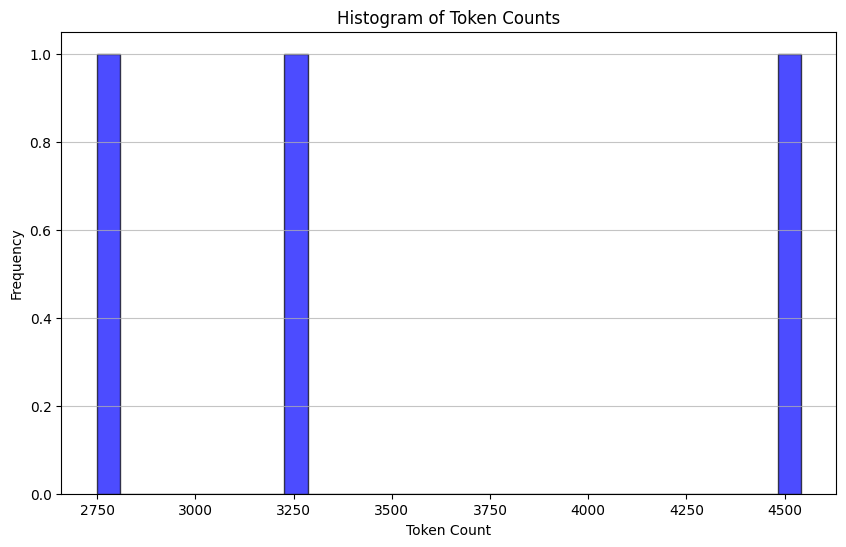

In [186]:
import matplotlib.pyplot as plt
import tiktoken
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

# LCEL docs
url = "https://python.langchain.com/docs/expression_language/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# LCEL w/ PydanticOutputParser (outside the primary LCEL docs)
url = "https://python.langchain.com/docs/how_to/output_parser_structured/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs_pydantic = loader.load()

# LCEL w/ Self Query (outside the primary LCEL docs)
url = "https://python.langchain.com/docs/how_to/self_query/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs_sq = loader.load()

# Doc texts
docs.extend([*docs_pydantic, * docs_sq])
docs_texts = [d.page_content for d in docs]

# Calculate the number of tokens for each document
counts = [num_tokens_from_string(d, "cl100k_base") for d in docs_texts]

# Plotting the historgram of token counts
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)

# diplay
plt.show()